60
Mosquito:
0 , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 20 , 21 , 22 , 23 , 24 , 25 , 26 , 27 , 28 , 29 , 30 , 31 , 32 , 33 , 34 , 35 , 36 , 37 , 38 , 39 , 40 , 41 , 42 , 43 , 44 , 45 , 46 , 47 , 48 , 49 , 50 , 51 , 52 , 53 , 54 , 55 , 56 , 57 , 58 , 59 , 60 , 61 , 62 , 63 , 64 , 65 , 66 , 67 , 68 , 69 , 70 , 71 , 72 , 73 , 74 , 75 , 76 , 77 , 78 , 79 , 80 , 81 , 82 , 83 , 84 , 85 , 86 , 87 , 88 , 89 , 90 , 91 , 92 , 93 , 94 , 95 , 96 , 97 , 98 , 99 , 100 , 101 , 102 , 103 , 104 , 105 , 106 , 107 , 108 , 109 , 110 , 111 , 112 , 113 , 114 , 115 , 116 , 117 , 118 , 119 , 120 , 121 , 122 , 123 , 124 , 125 , 126 , 127 , 128 , 129 , 130 , 131 , 132 , 133 , 134 , 135 , 136 , 137 , 138 , 139 , 140 , 141 , 142 , 143 , 144 , 145 , 146 , 147 , 148 , 149 , 150 , 151 , 152 , 153 , 154 , 155 , 156 , 157 , 158 , 159 , 160 , 161 , 162 , 163 , 164 , 165 , 166 , 167 , 168 , 169 , 170 , 171 , 172 , 173 , 174 , 175 , 176 , 177 , 178 , 179 , 180 , 181 , 182 ,

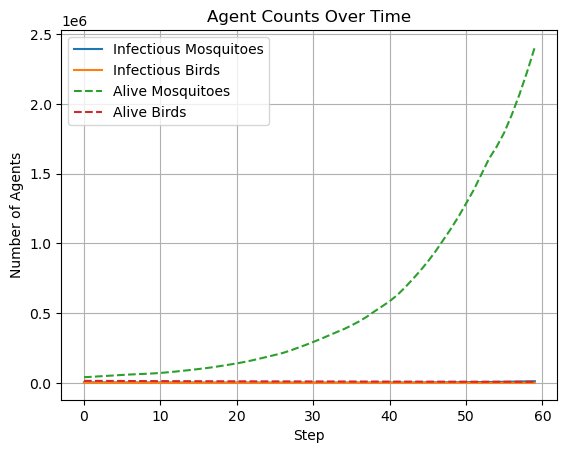

In [10]:
import numpy as np
import pandas as pd
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid
import random
import csv
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
import scipy.ndimage
import os

# Define the WNVParameters class
class WNVParameters:
    def __init__(self):
        self.transovarial_rate = 0.05  # Probability of vertical transmission in mosquitoes
        self.mosquito_life_span = 15  # Average lifespan of mosquitoes in days
        self.bird_life_span = 365  # Average lifespan of birds in days
        self.initial_mosquito_count = 40716
        self.initial_bird_count = 15296
        self.initial_infectious_fraction = 0.1
        self.recovery_rate = 0.05  # Probability of recovery for infected birds
        self.grid_width = 921
        self.grid_height = 393
        self.startDOY = 170
        self.simulation_steps = 60

    def mosquito_birth_rate(self, T, P):
        optimal_temp = 25  # Optimal temperature for Culex mosquitoes
        optimal_precip = 80  # Optimal precipitation for mosquito breeding
        # Temperature factor remains the same
        temp_factor = np.exp(-0.02 * (T - optimal_temp) ** 2)  # Gaussian function for temperature
        # Ensure P doesn't go below a small positive value to avoid division by zero
        P = np.clip(P, 1e-6, None)  # Clip P to avoid division by zero
        
        # Adjust the precipitation factor with a wider Gaussian curve
        precip_factor = np.where(P < 25,
                                np.exp(-0.0005 * (P - optimal_precip) ** 2) * (P / 25),
                                np.where(P <= 100,
                                        np.exp(-0.0005 * (P - optimal_precip) ** 2),
                                        np.exp(-0.0005 * (P - optimal_precip) ** 2) * (100 / P)))
        
        # Combine factors with baseline birth rate
        return 0.07 + 0.2 * temp_factor * precip_factor

    def egg_to_larvae_rate(self, T, P):
        optimal_temp = 25  # Optimal temperature for mosquito eggs
        optimal_precip = 70  # Optimal precipitation for mosquito breeding
        temp_factor = np.exp(-0.02 * (T - optimal_temp) ** 2)  # Wider Gaussian function for temperature
        precip_factor = np.exp(-0.01 * (P - optimal_precip) ** 2)  # Wider Gaussian function for precipitation
        return 0.1 + 0.2 * temp_factor * precip_factor
    
    def bird_birth_rate(self, T):
        optimal_temp = 20  # Optimal temperature for American crows
        variance = 0.005  # Decrease this value to make the curve wider
        temp_factor = np.exp(-variance * (T - optimal_temp) ** 2)  # Gaussian function for temperature
        return 0.08 * temp_factor * 0.5  # Decrease multiplier to make the peak lower

    def mosquito_death_rate(self, T):
        optimal_temp = 30  # Optimal temperature for Culex mosquitoes
        temp_factor = 0.05 + np.exp(0.01 * (T - optimal_temp) ** 2)  # Inverse Gaussian function for temperature
        return 0.05 * temp_factor

    def bird_death_rate(self, T):
        optimal_temp = 35  # Optimal temperature for American crows
        spread = 15  # Spread factor to control the steepness of the curve
        temp_factor = np.exp(-((T - optimal_temp) ** 2) / (2 * spread ** 2))
        # Adjusted to make the minimum death rate higher
        return 0.04 * (1 - temp_factor)

    def infection_probability(self, T):
        optimal_temp = 25  # Optimal temperature for WNV transmission
        spread = 10  # Spread factor to control the steepness of the curve
        temp_factor = np.exp(-((T - optimal_temp) ** 2) / (2 * spread ** 2))
        return 0.1 * temp_factor

# Define GISDataHandler class
class GISDataHandler:
    def __init__(self, width, height, days, startDOY, mock=False):
        self.data_Temp_all = []
        self.data_Precipitation_all = []
        self.days = days
        self.startDOY = startDOY
        columns = ['LAT', 'LON', 'YEAR', 'DOY', 'Temp', 'Humidity', 'Precipitation']
        file_path = 'combined_data.csv'
        self.climate_data = pd.read_csv(file_path, usecols=range(len(columns)), names=columns, skiprows=1)
        self.get_all_climate_data()
        return
    
    def resize_Dataframe(self, df):
        df = df.reset_index(drop=True)
        df.columns = range(df.shape[1])
        data = df.to_numpy()
        df = scipy.ndimage.zoom(data, (392 / data.shape[0], 920 / data.shape[1]), order=1)
        df = pd.DataFrame(df)
        return df

    def daily_Climate(self, DOY):
        data_Temp = self.climate_data[self.climate_data['DOY'] == DOY].pivot_table(index='LAT', columns='LON', values='Temp', aggfunc='mean')
        data_Humidity = self.climate_data[self.climate_data['DOY'] == DOY].pivot_table(index='LAT', columns='LON', values='Humidity', aggfunc='mean')
        data_Precipitation = self.climate_data[self.climate_data['DOY'] == DOY].pivot_table(index='LAT', columns='LON', values='Precipitation', aggfunc='mean')
        return (data_Temp, data_Humidity, data_Precipitation)
    
    def get_all_climate_data(self):
        for i in range(self.days):
            (data_Temp, data_Humidity, data_Precipitation) = self.daily_Climate(self.startDOY + i)
            data_Temp = self.resize_Dataframe(data_Temp)
            data_Humidity = self.resize_Dataframe(data_Humidity)
            self.data_Temp_all.append(data_Temp)
            self.data_Precipitation_all.append(data_Humidity)
        print(len(self.data_Temp_all))
        return
    
    def get_environmental_data(self, x, y, day):
        return self.data_Temp_all[day].iloc[y-1, x-1], self.data_Precipitation_all[day].iloc[y-1, x-1]
    

# Define Mosquito agent
class Mosquito(Agent):
    def __init__(self, unique_id, model, state="egg", parent_state=None):
        super().__init__(unique_id, model)
        self.state = state
        self.parent_state = parent_state

    def step(self):
        day = self.model.schedule.steps
        x, y = self.pos
        T, P = self.model.gis_data.get_environmental_data(x, y, day)

        if self.state == "egg":
            if random.random() < self.model.parameters.egg_to_larvae_rate(T, P):
                self.state = "susceptible"
            elif random.random() < self.model.parameters.mosquito_death_rate(T):
                self.state = "dead"
        elif self.state == "susceptible":
            self.move()
            if random.random() < self.model.parameters.mosquito_death_rate(T):
                self.state = "dead"
            elif self.model.check_infection(self):
                self.state = "infectious"
            self.give_birth(T, P)
        elif self.state == "infectious":
            self.move()
            if random.random() < self.model.parameters.mosquito_death_rate(T):
                self.state = "dead"
            self.give_birth(T, P)

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(self.pos, moore=True, include_center=True, radius=self.random.randint(0, 1))
        new_position = random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def give_birth(self, T, P):
        if random.random() < self.model.parameters.mosquito_birth_rate(T, P):
            x, y = self.pos
            new_mosquito = Mosquito(self.model.next_id(), self.model, state="egg", parent_state=self.state)
            self.model.schedule.add(new_mosquito)
            self.model.grid.place_agent(new_mosquito, (x, y))

# Define Bird agent
class Bird(Agent):
    def __init__(self, unique_id, model, state="susceptible"):
        super().__init__(unique_id, model)
        self.state = state

    def step(self):
        day = self.model.schedule.steps
        x, y = self.pos
        T, P = self.model.gis_data.get_environmental_data(x, y, day)

        if self.state == "susceptible":
            self.move()
            if random.random() < self.model.parameters.bird_death_rate(T):
                self.state = "dead"
            elif self.model.check_infection(self):
                self.state = "infectious"
            # self.give_birth(T)
        elif self.state == "infectious":
            self.move()
            if random.random() < self.model.parameters.bird_death_rate(T):
                self.state = "dead"
            elif random.random() < self.model.parameters.recovery_rate:
                self.state = "recovered"
            # self.give_birth(T)
        elif self.state == "recovered":
            if random.random() < self.model.parameters.bird_death_rate(T):
                self.state = "dead"

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(self.pos, moore=True, include_center=True, radius=self.random.randint(0, 1))
        new_position = random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def give_birth(self, T):
        if random.random() < self.model.parameters.bird_birth_rate(T):
            x, y = self.pos
            new_bird = Bird(self.model.next_id(), self.model, state="susceptible")
            self.model.schedule.add(new_bird)
            self.model.grid.place_agent(new_bird, (x, y))

# Define WNVModel
class WNVModel(Model):
    def __init__(self, parameters, mock=True):
        super().__init__()
        self.parameters = parameters
        # self.grid = MultiGrid(self.parameters.grid_width, self.parameters.grid_height, True)
        self.grid = MultiGrid(self.parameters.grid_width, self.parameters.grid_height, torus=False)
        self.schedule = RandomActivation(self)
        self.gis_data = GISDataHandler(self.parameters.grid_width, self.parameters.grid_height, self.parameters.simulation_steps, self.parameters.startDOY, mock=mock)
        self.initialize_agents()
        self.infectious_counts = {'mosquitoes': [], 'birds': []}
        self.alive_counts = {'mosquitoes': [], 'birds': []}
        self.results_file = open('simulation_results.csv', 'w', newline='')
        self.csv_writer = csv.writer(self.results_file)
        self.csv_writer.writerow(['step', 'agent_id', 'agent_type', 'x', 'y', 'state'])

    def initialize_agents(self):
        # Initialize Mosquito (using the distribution data)
        print('Mosquito:')
        initial_infectious_mosquitoes = int(self.parameters.initial_mosquito_count * self.parameters.initial_infectious_fraction)
        culex_distribution = pd.read_parquet('culex_distribution.parquet')
        mosquito_id = 0  # Starting ID for mosquitoes
        for x in range(culex_distribution.shape[0]):  # Rows
            print(x, ',', end=' ')
            for y in range(culex_distribution.shape[1]):  # Columns
                # print(x, ' ', y)
                num_groups = culex_distribution.iloc[x, y]  # Number of mosquito groups in this cell
                for _ in range(int(num_groups)):  # Each group represents 100 mosquitoes
                    # for _ in range(100):
                    state = "infectious" if mosquito_id < initial_infectious_mosquitoes else "susceptible"
                    mosquito = Mosquito(mosquito_id, self, state)
                    self.schedule.add(mosquito)
                    self.grid.place_agent(mosquito, (y, x))
                    mosquito_id += 1

        print('')

        # Initialize Birds (using the distribution data)
        print('Birds:')
        initial_infectious_birds = int(self.parameters.initial_bird_count * self.parameters.initial_infectious_fraction)
        bird_distribution = pd.read_parquet('amerob_2022-09-06.parquet')
        bird_id = 0  # Starting ID for birds
        for x in range(bird_distribution.shape[0]):  # Rows
            print(x, ',', end=' ')
            for y in range(bird_distribution.shape[1]): # Columns
                num_groups = bird_distribution.iloc[x, y]
                for _ in range(int(num_groups)):
                    state = "infectious" if bird_id < initial_infectious_birds else "susceptible"
                    bird = Bird(bird_id, self, state)
                    self.schedule.add(bird)
                    self.grid.place_agent(bird, (y, x))
                    bird_id += 1


    def step(self):
        self.schedule.step()
        self.save_results()
        self.collect_data()

    def save_results(self):
        for agent in self.schedule.agents:
            self.csv_writer.writerow([self.schedule.steps, agent.unique_id, type(agent).__name__, agent.pos[0], agent.pos[1], agent.state])

    def collect_data(self):
        mosquito_infectious_count = sum(1 for agent in self.schedule.agents if isinstance(agent, Mosquito) and agent.state == "infectious")
        bird_infectious_count = sum(1 for agent in self.schedule.agents if isinstance(agent, Bird) and agent.state == "infectious")
        mosquito_alive_count = sum(1 for agent in self.schedule.agents if isinstance(agent, Mosquito) and agent.state != "dead")
        bird_alive_count = sum(1 for agent in self.schedule.agents if isinstance(agent, Bird) and agent.state != "dead")

        self.infectious_counts['mosquitoes'].append(mosquito_infectious_count)
        self.infectious_counts['birds'].append(bird_infectious_count)
        self.alive_counts['mosquitoes'].append(mosquito_alive_count)
        self.alive_counts['birds'].append(bird_alive_count)

    def __del__(self):
        self.results_file.close()

    def check_infection(self, agent):
        x, y = agent.pos
        day = self.schedule.steps
        T, P = self.gis_data.get_environmental_data(x, y, day)
        neighbors = self.grid.get_neighbors(agent.pos, moore=True, include_center=False)

        if isinstance(agent, Mosquito):
            for neighbor in neighbors:
                if isinstance(neighbor, Bird) and neighbor.state == "infectious":
                    return random.random() < self.parameters.infection_probability(T)
        elif isinstance(agent, Bird):
            for neighbor in neighbors:
                if isinstance(neighbor, Mosquito) and neighbor.state == "infectious":
                    return random.random() < self.parameters.infection_probability(T)
        return False

# Visualization function
def Visualize_simulation(model, num_steps, map_image_path='MapV3.png', output_folder='simulation_images'):
    img = mpimg.imread(map_image_path)

    num = 1
    print('')
    for step in range(num_steps):
        print('step = ', num)
        model.step()
        num = num + 1

        fig, ax = plt.subplots(figsize=(16, 9), dpi=100)
        ax.imshow(img, extent=[0, model.grid.width, 0, model.grid.height])
        x_mosquitoes = [agent.pos[0] for agent in model.schedule.agents if isinstance(agent, Mosquito) and agent.state != "dead"]
        y_mosquitoes = [agent.pos[1] for agent in model.schedule.agents if isinstance(agent, Mosquito) and agent.state != "dead"]
        x_birds = [agent.pos[0] for agent in model.schedule.agents if isinstance(agent, Bird) and agent.state != "dead"]
        y_birds = [agent.pos[1] for agent in model.schedule.agents if isinstance(agent, Bird) and agent.state != "dead"]
        ax.scatter(x_mosquitoes, y_mosquitoes, c='red', label='Mosquitoes', s=0.7, alpha=0.6)
        ax.scatter(x_birds, y_birds, c='blue', label='Birds', s=1, alpha=0.5)
        ax.set_xlim(0, model.grid.width)
        ax.set_ylim(0, model.grid.height)
        ax.set_title(f'Step {step + 1}')
        ax.legend()
        plt.savefig(os.path.join(output_folder, f'step_{step + 1:03d}.png'))
        plt.close(fig)

# Plot infectious counts
def plot_infectious_counts(model):
    steps = range(len(model.infectious_counts['mosquitoes']))
    plt.figure()
    plt.plot(steps, model.infectious_counts['mosquitoes'], label='Infectious Mosquitoes')
    plt.plot(steps, model.infectious_counts['birds'], label='Infectious Birds')
    plt.plot(steps, model.alive_counts['mosquitoes'], label='Alive Mosquitoes', linestyle='--')
    plt.plot(steps, model.alive_counts['birds'], label='Alive Birds', linestyle='--')
    plt.xlabel('Step')
    plt.ylabel('Number of Agents')
    plt.title('Agent Counts Over Time')
    plt.legend()
    plt.grid(True)
    plt.savefig('agent_counts.png')
    plt.show()

# Running the model
if __name__ == "__main__":
    parameters = WNVParameters()
    model = WNVModel(parameters)
    Visualize_simulation(model, num_steps=parameters.simulation_steps)
    plot_infectious_counts(model)
